In [8]:
import os
import time

import numpy as np

import igraph
from igraph import Graph

import torch
from torch import nn, optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F

from tqdm import tqdm
from scipy.stats import pearsonr
from graphviz import Digraph
import scipy

import matplotlib.pyplot as plt

Experimenting with the performance predictor of metaD2A, $f_{\omega}$. 

In [36]:
from igraph import *


g = Graph(directed=True)
g.add_vertices(4)
# , (1, 2), (1, 3), (1, 4), 0, 2), (0, 3), (0, 4), (2, 3), (2, 4), (3, 4)
g.add_edges([(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)])

print(g)

IGRAPH D--- 4 6 --
+ edges:
0->1 0->2 0->3 1->2 1->3 2->3


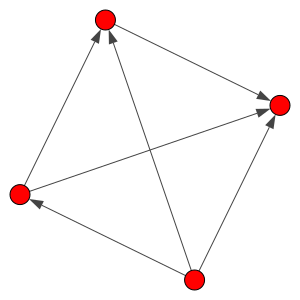

In [37]:

igraph.plot(g, bbox=(0, 0, 300, 300))

In [38]:
g.get_edgelist()

[(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]

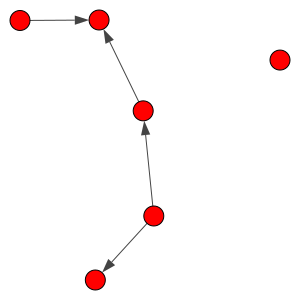

In [39]:
igraph.plot(g.linegraph(), bbox=(0, 0, 300, 300))

In [386]:
def parse(alpha, k, primitives=PRIMITIVES_FEWSHOT):
    """
    parse continuous alpha to discrete gene.
    alpha is ParameterList:
    ParameterList [
        Parameter(n_edges1, n_ops),
        Parameter(n_edges2, n_ops),
        ...
    ]

    gene is list:
    [
        [('node1_ops_1', node_idx), ..., ('node1_ops_k', node_idx)],
        [('node2_ops_1', node_idx), ..., ('node2_ops_k', node_idx)],
        ...
    ]
    each node has two edges (k=2) in CNN.
    """
    gene = []
    # assert PRIMITIVES_FEWSHOT[-1] == "none"  # assume last PRIMITIVE
    # is 'none'

    # 1) Convert the mixed op to discrete edge (single op) by choosing
    #    top-1 weight edge
    # 2) Choose top-k edges per node by edge score (top-1 weight in edge)
    for edges in alpha:
        # edges: Tensor(n_edges, n_ops)
        edge_max, primitive_indices = torch.topk(
            edges[:, :], 1
        )  # ignore 'none' ##removed none
        topk_edge_values, topk_edge_indices = torch.topk(edge_max.view(-1), k)
        print(topk_edge_indices)
        
        node_gene = []
        for edge_idx in topk_edge_indices:
            prim_idx = primitive_indices[edge_idx]
            prim = primitives[prim_idx]
            node_gene.append((prim, edge_idx.item()))

        gene.append(node_gene)

    return gene

def plot(genotype, file_path, caption=None):
    """ make DAG plot and save to file_path as .png """
    edge_attr = {"fontsize": "20", "fontname": "times"}
    node_attr = {
        "style": "filled",
        "shape": "rect",
        "align": "center",
        "fontsize": "20",
        "height": "0.5",
        "width": "0.5",
        "penwidth": "2",
        "fontname": "times",
    }
    g = Digraph(format="png", edge_attr=edge_attr, node_attr=node_attr, engine="dot")
    g.body.extend(["rankdir=LR"])

    # input nodes
    g.node("c_{k-2}", fillcolor="darkseagreen2")
    g.node("c_{k-1}", fillcolor="darkseagreen2")

    # intermediate nodes
    n_nodes = len(genotype)
    for i in range(n_nodes):
        g.node(str(i), fillcolor="lightblue")

    for i, edges in enumerate(genotype):
        for op, j in edges:
            if j == 0:
                u = "c_{k-2}"
            elif j == 1:
                u = "c_{k-1}"
            else:
                u = str(j - 2)

            v = str(i)
            g.edge(u, v, label=op, fillcolor="gray")

    # output node
    g.node("c_{k}", fillcolor="palegoldenrod")
    for i in range(n_nodes):
        g.edge(str(i), "c_{k}", fillcolor="gray")

    # add image caption
    if caption:
        g.attr(label=caption, overlap="false", fontsize="20", fontname="times")

    g.render(file_path, view=False)

In [3]:
PRIMITIVES_FEWSHOT = [
    "max_pool_3x3",
    "avg_pool_3x3",
    "skip_connect",  # identity
    "conv_1x5_5x1",
    "conv_3x3",
    "sep_conv_3x3",
    # "sep_conv_5x5",  # remove
    "dil_conv_3x3",
    # "dil_conv_5x5",  # remove
    # "none",  # remove
]

n_nodes = 3
n_ops = 7

alpha_normal = []
alpha_pw_normal = []

for i in range(n_nodes):
    alpha_normal.append(nn.Parameter(
        1e-3 * torch.randn(i + 2, n_ops)* 0.5 + 1))
    
    num_comb = int(scipy.special.binom(i + 2, 2))
    alpha_pw_normal.append(
        nn.Parameter(1e-3 * torch.randn(num_comb)))
    
alpha_normal

[Parameter containing:
 tensor([[0.9999, 1.0003, 1.0000, 0.9996, 0.9991, 1.0008, 0.9999],
         [0.9989, 1.0001, 1.0002, 1.0006, 1.0009, 1.0013, 0.9996]],
        requires_grad=True),
 Parameter containing:
 tensor([[1.0008, 1.0006, 1.0001, 1.0000, 0.9999, 1.0000, 1.0004],
         [1.0013, 0.9989, 1.0006, 1.0001, 0.9997, 1.0002, 1.0001],
         [0.9999, 0.9996, 0.9996, 0.9999, 1.0002, 1.0006, 1.0001]],
        requires_grad=True),
 Parameter containing:
 tensor([[1.0001, 0.9994, 1.0008, 1.0004, 0.9996, 0.9996, 0.9993],
         [1.0005, 0.9999, 0.9998, 0.9993, 1.0004, 0.9999, 1.0006],
         [0.9999, 0.9998, 1.0005, 1.0006, 1.0000, 1.0003, 1.0001],
         [0.9999, 0.9997, 1.0002, 1.0003, 1.0001, 0.9997, 0.9996]],
        requires_grad=True)]

In [174]:
def parse(alpha, k, primitives=PRIMITIVES_FEWSHOT):
    gene = []
    for edges in alpha:
        edge_max, primitive_indices = torch.topk(
            edges[:, :], 1
        )
        print(edge_max.view(-1))
        
        topk_edge_values, topk_edge_indices = torch.topk(edge_max.view(-1), k)
        
        print("top_k")
        print(topk_edge_values)
        print(topk_edge_indices, "\n")
        
        node_gene = []
        for edge_idx in topk_edge_indices:
            prim_idx = primitive_indices[edge_idx]
            prim = primitives[prim_idx]
            node_gene.append((prim, edge_idx.item()))

        gene.append(node_gene)

    return gene

print(alpha_normal, "\n")

geno = parse(alpha_normal, k=2)

[Parameter containing:
tensor([[0.9992, 1.0003, 1.0000, 0.9999, 1.0012, 0.9997, 0.9998],
        [1.0002, 1.0003, 0.9996, 1.0004, 1.0000, 1.0001, 0.9999]],
       requires_grad=True), Parameter containing:
tensor([[1.0007, 0.9997, 1.0002, 1.0001, 0.9997, 1.0004, 0.9997],
        [1.0001, 1.0003, 1.0004, 1.0006, 1.0000, 0.9992, 1.0004],
        [0.9995, 0.9998, 1.0007, 1.0007, 1.0007, 0.9996, 1.0004]],
       requires_grad=True), Parameter containing:
tensor([[0.9997, 0.9996, 1.0000, 1.0006, 0.9993, 1.0004, 1.0009],
        [1.0009, 1.0004, 1.0009, 1.0005, 0.9999, 1.0006, 0.9994],
        [1.0003, 0.9998, 1.0008, 0.9998, 1.0001, 1.0002, 0.9996],
        [1.0001, 1.0005, 1.0005, 0.9986, 1.0000, 0.9998, 0.9998]],
       requires_grad=True)] 

tensor([1.0012, 1.0004], grad_fn=<ViewBackward>)
top_k
tensor([1.0012, 1.0004], grad_fn=<TopkBackward>)
tensor([0, 1]) 

tensor([1.0007, 1.0006, 1.0007], grad_fn=<ViewBackward>)
top_k
tensor([1.0007, 1.0007], grad_fn=<TopkBackward>)
tensor([2, 0]) 



In [547]:
k = 2

topk_edges = []

for edges in alpha_normal:
    # edges: Tensor(n_edges, n_ops)
    edge_max, primitive_indices = torch.topk(edges[:, :], 1)
    topk_edge_values, topk_edge_indices = torch.topk(edge_max.view(-1), k)
    
#     print(topk_edge_indices.numpy())
    topk_edges.append(topk_edge_indices.numpy())

topk_edges = np.array(topk_edges)

In [551]:
alpha_normal

[Parameter containing:
 tensor([[0.9989, 1.0005, 0.9996, 1.0002, 1.0002, 0.9995, 1.0004],
         [0.9988, 0.9999, 0.9989, 0.9999, 1.0002, 1.0003, 0.9992]],
        requires_grad=True),
 Parameter containing:
 tensor([[1.0006, 0.9993, 1.0004, 0.9990, 0.9994, 1.0002, 1.0004],
         [1.0014, 0.9999, 0.9995, 1.0003, 0.9985, 0.9995, 0.9994],
         [0.9993, 0.9995, 1.0006, 1.0004, 1.0001, 0.9999, 1.0009]],
        requires_grad=True),
 Parameter containing:
 tensor([[1.0002, 1.0003, 1.0003, 1.0002, 1.0004, 1.0000, 1.0007],
         [1.0007, 0.9999, 0.9997, 1.0000, 1.0007, 1.0001, 1.0003],
         [1.0002, 1.0001, 0.9997, 1.0004, 0.9998, 0.9991, 1.0008],
         [1.0009, 1.0009, 0.9999, 1.0000, 1.0000, 1.0001, 1.0005]],
        requires_grad=True)]

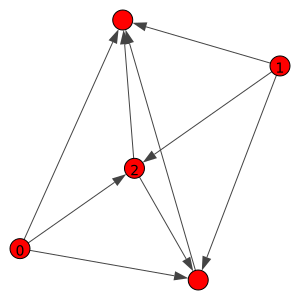

In [554]:

n_nodes = 3+2

g = Graph(directed=True)
g.add_vertices(n_nodes)

for i, edges in enumerate(alpha_normal):
#     print(f"node {i}")
    g.vs[i]['label'] = i
    for j, edge in enumerate(edges):
#         print(j, i+2)
        g.add_edges([(j, i+2)])
        
        
ig.plot(g, bbox=(0, 0, 300, 300))

In [4]:
nasbench201 = torch.load(
    '/home/rob/Git/meta-fsl-nas/metanas/metanas/meta_predictor/data/nasbench201.pt')

PRIMITIVES_NAS_BENCH_201 = [
    'none', 'skip_connect', 'nor_conv_1x1', 'nor_conv_3x3', 'avg_pool_3x3']



In [5]:
n_nodes = 4
max_n = 3
n_ops = 5

alpha_normal = []
alpha_pw_normal = []

for i in range(n_nodes):
    alpha_normal.append(nn.Parameter(
        1e-3 * torch.randn(i + 2, n_ops)))
    
    num_comb = int(scipy.special.binom(i + 2, 2))
    alpha_pw_normal.append(
        nn.Parameter(1e-3 * torch.randn(num_comb)))

def parse(alpha, k, primitives=PRIMITIVES_FEWSHOT):
    gene = []
    for edges in alpha:
        # edges: Tensor(n_edges, n_ops)
        edge_max, primitive_indices = torch.topk(
            edges[:, :], 1
        )  # ignore 'none' ##removed none
        topk_edge_values, topk_edge_indices = torch.topk(edge_max.view(-1), k)
        node_gene = []
        for edge_idx in topk_edge_indices:
            prim_idx = primitive_indices[edge_idx]
            prim = primitives[prim_idx]
            node_gene.append((prim, edge_idx.item()))

        gene.append(node_gene)
    return gene


geno = parse(alpha_normal, 2, primitives=PRIMITIVES_NAS_BENCH_201)
geno

# geno = [(('nor_conv_1x1', 0), ), # node-1 
#    (('nor_conv_1x1', 0), ('nor_conv_1x1', 1)), # node-2
#    (('nor_conv_1x1', 0), ('nor_conv_1x1', 1), ('nor_conv_1x1', 2))] # node-3

geno1 = [[('nor_conv_1x1', 0), ],
         [('nor_conv_1x1', 0), ('skip_connect', 1)],
         [('skip_connect', 0), ('skip_connect', 1),  ('avg_pool_3x3', 2)]]

In [565]:
# NAS-Bench matrix to igraph
def decode_NAS_BENCH_201_8_to_igraph(row):
    if type(row) == str:
        row = eval(row)  # convert string to list of lists
    n = len(row)
    g = igraph.Graph(directed=True)
    g.add_vertices(n)
    for i, node in enumerate(row):
        g.vs[i]['type'] = node[0]
        g.vs[i]['label'] = node[0]
        if i < (n - 2) and i > 0:
            g.add_edge(i, i + 1)  # always connect from last node
        for j, edge in enumerate(node[1:]):
            if edge == 1:
                g.add_edge(j, i)
    return g#, n

In [559]:
nasbench201['arch']['matrix'][0], nasbench201['arch']['igraph'][0]

([[0],
  [6, 1],
  [4, 1, 0],
  [3, 0, 1, 0],
  [4, 1, 0, 0, 0],
  [3, 0, 1, 0, 0, 0],
  [3, 0, 0, 1, 1, 0, 0],
  [1, 0, 0, 0, 0, 1, 1, 1]],
 <igraph.Graph at 0x7fde4374b650>)

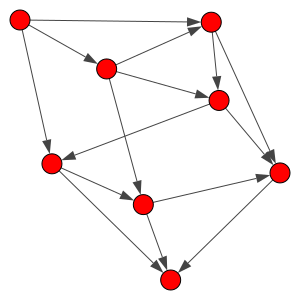

In [563]:

igraph.plot(nasbench201['arch']['igraph'][0], bbox=(0, 0, 300, 300))

In [616]:
g, _ = decode_NAS_BENCH_201_8_to_igraph(nasbench201['arch']['matrix'][1])

igraph.plot(g, bbox=(0, 0, 300, 300))

TypeError: 'Graph' object is not iterable

In [617]:
# NAS-Bench matrix to igraph
def decode_NAS_BENCH_201_8_to_igraph(row):
    if type(row) == str:
        row = eval(row)  # convert string to list of lists
    n = len(row)
    g = igraph.Graph(directed=True)
    g.add_vertices(n)
    for i, node in enumerate(row):
        g.vs[i]['type'] = node[0]
        if i < (n - 2) and i > 0:
            g.add_edge(i, i + 1)  # always connect from last node
            
        
#         for j, edge in enumerate(node[1:]):
#             if edge == 1:
#                 g.add_edge(j, i)
#     return g, n

g, _ = decode_NAS_BENCH_201_8_to_igraph(nasbench201['arch']['matrix'][0])

In [618]:
def decode_igraph_to_NAS201_matrix(g):
    m = [[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0]]
    xys = [(1, 0), (2, 0), (2, 1), (3, 0), (3, 1), (3, 2)]
    for i, xy in enumerate(xys):
        m[xy[0]][xy[1]] = float(g.vs[i + 1]['type']) - 2
    return np.array(m)


decode_igraph_to_NAS201_matrix(g)

array([[0., 0., 0., 0.],
       [4., 0., 0., 0.],
       [2., 1., 0., 0.],
       [2., 1., 1., 0.]])

In [516]:
import copy

class Structure:
    def __init__(self, genotype):
        self.node_num = len(genotype) + 1
        self.nodes    = []
        self.node_N   = [] 
        
        # TODO: Original code does validity checks
        for idx, node_info in enumerate(genotype):
            self.node_N.append(len(node_info))
            self.nodes.append(tuple(copy.deepcopy(node_info)))
            
    def to_str(self):
        strings = []
        for node_info in self.nodes:
            string = '|'.join([x[0]+'~{:}'.format(x[1]) for x in node_info])
            string = '|{:}|'.format(string)
            strings.append(string)
        return '+'.join(strings)
    
source = Structure(geno).to_str()
print(source)


|nor_conv_1x1~1|skip_connect~0|+|nor_conv_3x3~1|none~0|+|none~3|nor_conv_1x1~1|+|skip_connect~0|none~2|


In [543]:
# full_target = nasbench201['arch']['igraph']
# full_source = nasbench201['arch']['str']


# # [full_target[full_source.index(_)] for _ in source]
# full_target[full_source.index(source)]

#### Methods to convert my search space to iGraphs


In [517]:
# Settings of the MobileNetV3 search space
def load_graph_config(graph_data_name, nvt, data_path):
	if graph_data_name is not 'ofa_mbv3':
		raise NotImplementedError(graph_data_name)
	max_n=20
	graph_config = {}
	graph_config['num_vertex_type'] = nvt + 2  # original types + start/end types
	graph_config['max_n'] = max_n + 2  # maximum number of nodes
	graph_config['START_TYPE'] = 0  # predefined start vertex type
	graph_config['END_TYPE'] = 1  # predefined end vertex type
	
	return graph_config

# For metaNAS we want 3?
nvt = 3+2 # 21 # Without in/out node
max_n = 3+2 # 20 + 2? 

In [518]:
def is_valid_DAG(g, START_TYPE=0, END_TYPE=1):
	res = g.is_dag()
	n_start, n_end = 0, 0
	for v in g.vs:
		if v['type'] == START_TYPE:
			n_start += 1
		elif v['type'] == END_TYPE:
			n_end += 1
		if v.indegree() == 0 and v['type'] != START_TYPE:
			return False
		if v.outdegree() == 0 and v['type'] != END_TYPE:
			return False
	return res and n_start == 1 and n_end == 1

In [622]:

nasbench201['arch']['matrix'][2]

[[0],
 [6, 1],
 [5, 1, 0],
 [5, 0, 1, 0],
 [6, 1, 0, 0, 0],
 [6, 0, 1, 0, 0, 0],
 [6, 0, 0, 1, 1, 0, 0],
 [1, 0, 0, 0, 0, 1, 1, 1]]

In [11]:
# NAS-Bench matrix to igraph
# if type(row) == str:
#     row = eval(row)  # convert string to list of lists
# n = len(row)
# g = igraph.Graph(directed=True)
# g.add_vertices(n)
# for i, node in enumerate(row):
#     g.vs[i]['type'] = node[0]
#     g.vs[i]['label'] = node[0]
#     if i < (n - 2) and i > 0:
#         g.add_edge(i, i + 1)  # always connect from previous node
#     for j, edge in enumerate(node[1:]):
#         if edge == 1:
#             g.add_edge(j, i)
# return g

nasbench201['arch']['matrix'][1]

[[0],
 [5, 1],
 [5, 1, 0],
 [6, 0, 1, 0],
 [3, 1, 0, 0, 0],
 [5, 0, 1, 0, 0, 0],
 [3, 0, 0, 1, 1, 0, 0],
 [1, 0, 0, 0, 0, 1, 1, 1]]

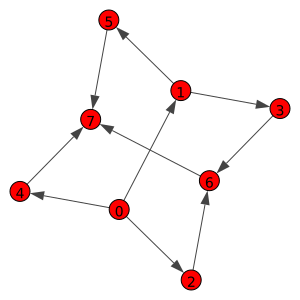

In [14]:

row = nasbench201['arch']['matrix'][1]
n = len(row)
g = igraph.Graph(directed=True)
g.add_vertices(n)

for i, node in enumerate(row):
    g.vs[i]['type'] = node[0]
    g.vs[i]['label'] = i
#     print(i, node[0], i<(n-2), i>0)
    # Ignore first node and last node
#     if i < (n-2) and i > 0:
#         g.add_edge(i, i+1)
    for j, edge in enumerate(node[1:]):
        if edge == 1:
            g.add_edge(j, i)

igraph.plot(g, bbox=(0, 0, 300, 300))

In [603]:

# To effectively encode the operation information as the node features,
# we represent edges of graphs in NAS-Bench201 as nodes, and 
# nodes of them as edges. Additionally, we add a starting node and an ending node to 
# the cell during training. 

def decode_igraph_to_NAS201_matrix(g):
    m = [[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0]]
    # All indices to check for entries in m
    xys = [(1, 0), (2, 0), (2, 1), (3, 0), (3, 1), (3, 2)]
    for i, xy in enumerate(xys):
        m[xy[0]][xy[1]] = float(g.vs[i + 1]['type']) - 2
    return np.array(m)

decode_igraph_to_NAS201_matrix(g)

array([[0., 0., 0., 0.],
       [3., 0., 0., 0.],
       [3., 4., 0., 0.],
       [1., 3., 1., 0.]])

In [601]:

nasbench201['arch']['matrix'][1]

[[0],
 [5, 1],
 [5, 1, 0],
 [6, 0, 1, 0],
 [3, 1, 0, 0, 0],
 [5, 0, 1, 0, 0, 0],
 [3, 0, 0, 1, 1, 0, 0],
 [1, 0, 0, 0, 0, 1, 1, 1]]

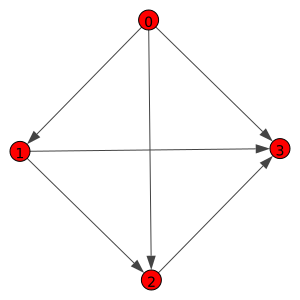

In [586]:

matrix = decode_igraph_to_NAS201_matrix(g)

g = Graph(directed=True)
g.add_vertices(4)

for i, row in enumerate(matrix):
    g.vs[i]['label'] = i
    for j, edge in enumerate(row):
        if edge != 0:
            g.add_edges([(j, i)])

# ig.plot(g, bbox=(0, 0, 300, 300))

In [ ]:
# TODO: Matrix to Metad2a matrix

m = []



# TODO: Metad2a matrix to iGraph (For MetaNAS)

[[0],
 [5, 1],
 [5, 1, 0],
 [6, 0, 1, 0],
 [3, 1, 0, 0, 0],
 [5, 0, 1, 0, 0, 0],
 [3, 0, 0, 1, 1, 0, 0],
 [1, 0, 0, 0, 0, 1, 1, 1]]

In [595]:
for v in g.vs:
    print(v)

igraph.Vertex(<igraph.Graph object at 0x7fde5456d150>, 0, {'type': 0, 'label': 0})
igraph.Vertex(<igraph.Graph object at 0x7fde5456d150>, 1, {'type': 5, 'label': 5})
igraph.Vertex(<igraph.Graph object at 0x7fde5456d150>, 2, {'type': 5, 'label': 5})
igraph.Vertex(<igraph.Graph object at 0x7fde5456d150>, 3, {'type': 6, 'label': 6})
igraph.Vertex(<igraph.Graph object at 0x7fde5456d150>, 4, {'type': 3, 'label': 3})
igraph.Vertex(<igraph.Graph object at 0x7fde5456d150>, 5, {'type': 5, 'label': 5})
igraph.Vertex(<igraph.Graph object at 0x7fde5456d150>, 6, {'type': 3, 'label': 3})
igraph.Vertex(<igraph.Graph object at 0x7fde5456d150>, 7, {'type': 1, 'label': 1})


In [593]:
m = [[0.0, 0.0, 0.0, 0.0],
     [0.0, 0.0, 0.0, 0.0],
     [0.0, 0.0, 0.0, 0.0],
     [0.0, 0.0, 0.0, 0.0]]

xys = [(1, 0), (2, 0), (2, 1), (3, 0), (3, 1), (3, 2)]


for i, xy in enumerate(xys):
    print(m[xy[0]][xy[1]])
    print(g.vs[i+1]["type"])
    print(g.vs[i+1]["type"]-2)
    m[xy[0]][xy[1]] = float(g.vs[i + 1]['type']) - 2
m

0.0
5
3
0.0
5
3
0.0
6
4
0.0
3
1
0.0
5
3
0.0
3
1


[[0.0, 0.0, 0.0, 0.0],
 [3.0, 0.0, 0.0, 0.0],
 [3.0, 4.0, 0.0, 0.0],
 [1.0, 3.0, 1.0, 0.0]]

In [592]:
nasbench201['arch']['str'][1]

'|nor_conv_3x3~0|+|nor_conv_3x3~0|avg_pool_3x3~1|+|skip_connect~0|nor_conv_3x3~1|skip_connect~2|'